# PyMC3 with NetworkX for BayesNets

In [1]:
## For debbugging
%load_ext autoreload

%aimport pmml.bn
%aimport pymcnet.net
%aimport pymcnet.expr_parse
%autoreload 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# from networkx.drawing.nx_pydot import graphviz_layout,write_dot # pygraphviz
%matplotlib inline


In [3]:
# import multiprocessing
import pymc3 as pm
import networkx as nx

## Helper Functions

In [4]:
from pymcnet.net import *

## Model 1 (lin. Regression)

In [5]:
# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

In [6]:
D = BayesianNetwork()
# root nodes can be defined staticly. 
D.add_node('alpha', mu=0, sd=10, dist_type='Normal')
D.add_node('beta', mu=0, sd=10, shape=2, dist_type='Normal')
D.add_node('sigma', sd=1, dist_type='HalfNormal')

# inheriting nodes need to have functions as attributes to be called at runtime. 
# You can reference the RV's associated with other nodes using BayesianNetwork().d(othernode)
D.add_node('Y_obs', 
           mu = lambda: D.d('alpha')+\
           D.d('beta')[0]*X1+\
           D.d('beta')[1]*X2,
           sd = lambda: D.d('sigma'),
#            exprs = {'mu':'alpha + beta*X2 + beta*X1',
#                     'sd': 'sigma'},
           observed=Y,
           dist_type='Normal')
D.add_edges_from([('alpha','Y_obs'),('beta','Y_obs')], var='mu')
D.add_edges_from([('sigma','Y_obs')], var='sd')
# [i for i in nx.ancestors(D, 'Y_obs') if D.edge[i]['Y_obs']['var']=='sd']

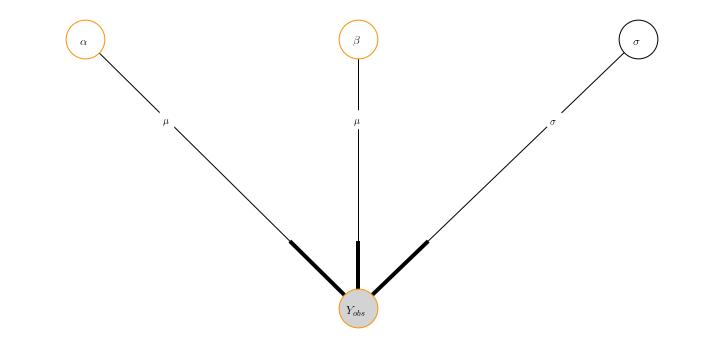

['alpha', 'beta', 'sigma', 'Y_obs']

In [7]:
draw_net(D, pretty=True)
D.nodes()

In [8]:
with pm.Model() as model:
    instantiate_pm(D)

alpha
root node; keys:  ['sd', 'mu']
beta
root node; keys:  ['sd', 'mu', 'shape']
sigma
root node; keys:  ['sd']
Y_obs
child node; keys:  ['observed', 'sd', 'mu']


In [9]:
with model:
#     step = pm.Metropolis()
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500 [00:01<00:00, 901.65it/s]


(1000,)

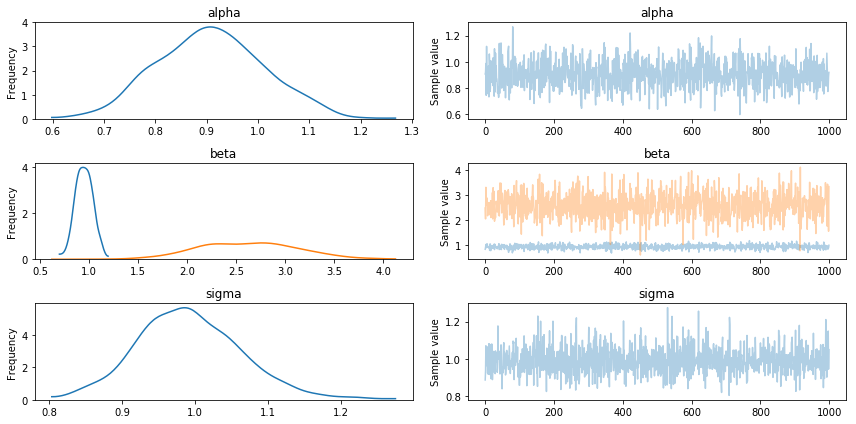

In [10]:
pm.traceplot(trace, combined=True);
trace.get_values('alpha').shape

`![pymc3_net](pymc3.png)`

## Model 2: Coal-mining Switchpoint

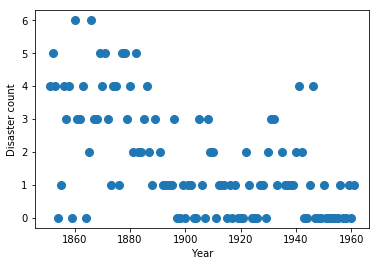

In [11]:
disaster_data = np.ma.masked_values([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                            3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                            2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
                            1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                            0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                            3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                            0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], value=-999)
year = np.arange(1851, 1962)

plt.plot(year, disaster_data, 'o', markersize=8);
plt.ylabel("Disaster count")
plt.xlabel("Year")

In [12]:
D = BayesianNetwork()
# root nodes can be defined staticly. 
D.add_node('switchpoint', 
           lower=year.min(),
           upper=year.max(), 
           dist_type='DiscreteUniform', 
           testval=1900)

D.add_node('early_rate', lam=1., dist_type='Exponential')
D.add_node('late_rate', lam=1., dist_type='Exponential')

# make sure to assume strings as input (node names) and use
# node dist as the vars
rate = lambda: pm.math.switch(1*(D.d('switchpoint') >= year), 
                                      D.d('early_rate'), 
                                      D.d('late_rate'))

# inheriting nodes need to have functions as attributes 
# to be called at runtime. 

D.add_node('disasters', 
           mu = rate,
           observed=disaster_data,
          dist_type='Poisson')

           
D.add_edges_from([('late_rate','disasters'),
                  ('early_rate','disasters'),
                  ('switchpoint','disasters')], var='mu')

In [13]:
D.predecessors('disasters')[::-1]

['switchpoint', 'early_rate', 'late_rate']

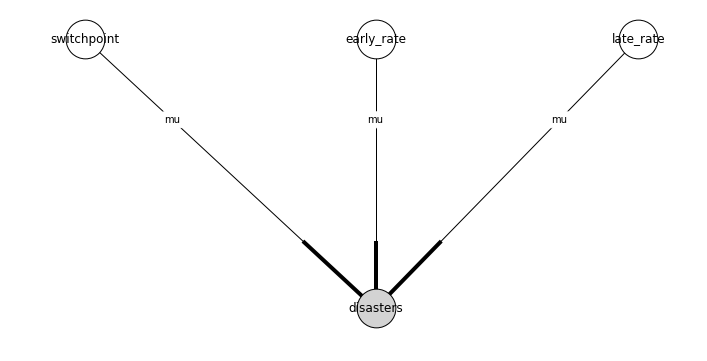

In [14]:
draw_net(D) # not pretty

In [15]:
with pm.Model() as model:
    instantiate_pm(D)

switchpoint
root node; keys:  ['upper', 'lower', 'testval']
early_rate
root node; keys:  ['lam']
late_rate
root node; keys:  ['lam']
disasters
child node; keys:  ['observed', 'mu']


In [16]:
with model:
    trace = pm.sample(10000)
    
    

Assigned Metropolis to switchpoint
Assigned NUTS to early_rate_log__
Assigned NUTS to late_rate_log__
Assigned Metropolis to disasters_missing
100%|██████████| 10500/10500 [00:57<00:00, 182.66it/s]


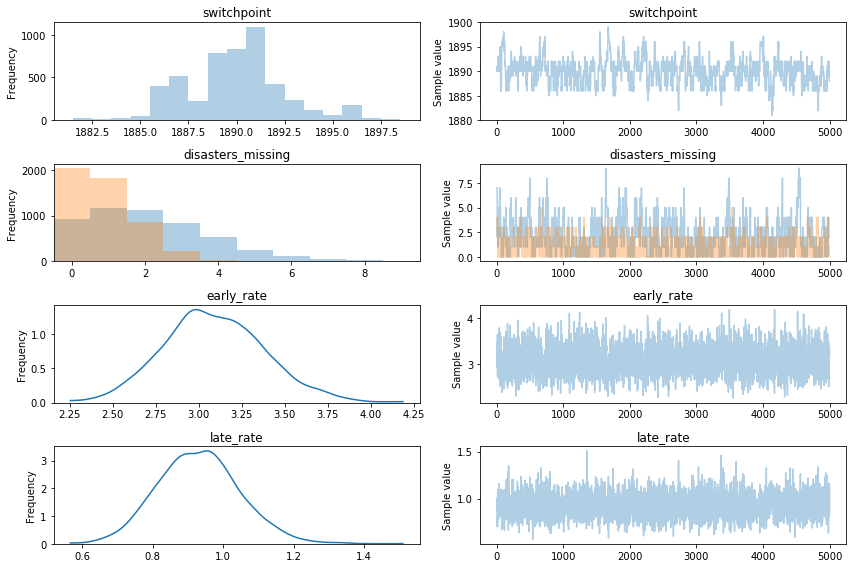

In [17]:
pm.traceplot(trace[5000:]);

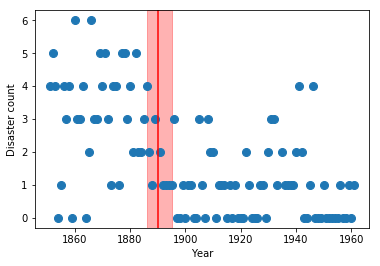

In [18]:
plt.plot(year, disaster_data, 'o', markersize=8);
data = trace[3000:].get_values('switchpoint')
plt.axvline(data.mean(), color='r')
plt.axvspan(np.percentile(data, 5), 
            np.percentile(data, 95), 
            alpha=.3, color='r')
plt.ylabel("Disaster count")
plt.xlabel("Year")


## Volatility

401


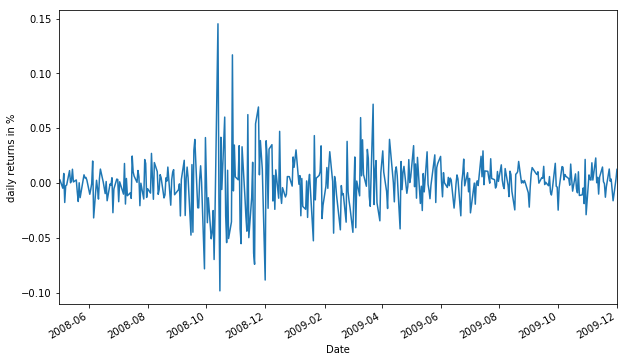

In [19]:
from pandas_datareader import data
import pandas as pd

returns = data.get_data_yahoo('SPY', start='2008-5-1', end='2009-12-1')['Adj Close'].pct_change()

print(len(returns))

returns.plot(figsize=(10, 6))
plt.ylabel('daily returns in %');

In [20]:
from pymc3.math import exp
from pymc3.distributions.timeseries import GaussianRandomWalk

D = BayesianNetwork()
D.add_node('nu',
           lam=1./10., testval=5.,
           dist_type='Exponential')
D.add_node('sigma', 
           lam=1./.02, testval=.1,
          dist_type='Exponential')
D.add_node('s',
           tau=lambda: D.d('sigma')**-2, 
           dist_type='GaussianRandomWalk', shape=len(returns))
D.add_edge('sigma', 's', var='tau')

D.add_node('P_v',
           var=lambda: exp(-2*D.d('s')), 
           dist_type='Deterministic')
D.add_edge('s', 'P_v', var='var')

D.add_node('r', 
           nu = lambda:D.d('nu'),
           lam = lambda: 1./D.d('P_v'), 
           observed = returns, dist_type='StudentT')
D.add_edge('nu', 'r', var='nu')
D.add_edge('P_v', 'r', var='lam')

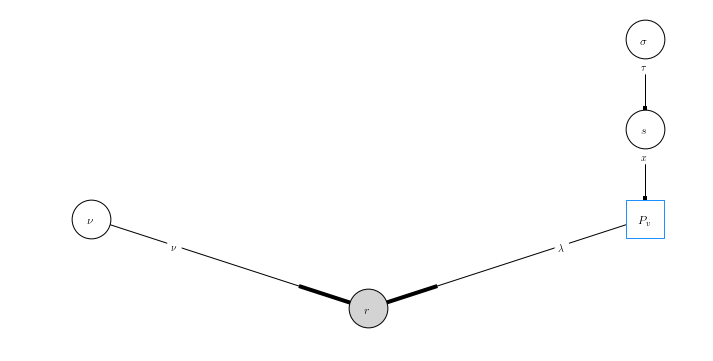

In [21]:
draw_net(D, pretty=True)

In [22]:
with pm.Model() as model:
    instantiate_pm(D)

nu
root node; keys:  ['lam', 'testval']
sigma
root node; keys:  ['lam', 'testval']
s
child node; keys:  ['shape', 'tau']
P_v
child node; keys:  ['var']
r
child node; keys:  ['observed', 'lam', 'nu']


In [23]:
with model:
    trace=pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [01:49<00:00, 22.78it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e4936f2b0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f7e49429f60>]], dtype=object)

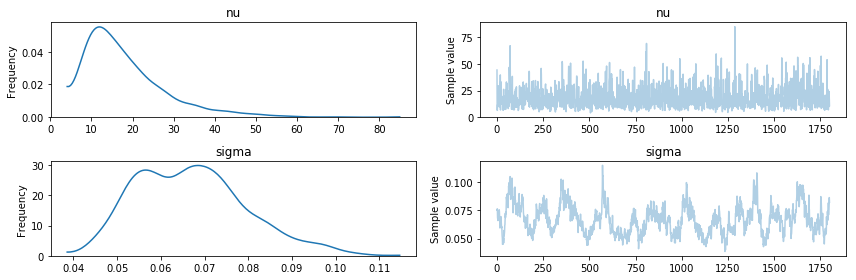

In [24]:
pm.traceplot(trace[200:], [D.d('nu'), D.d('sigma')])

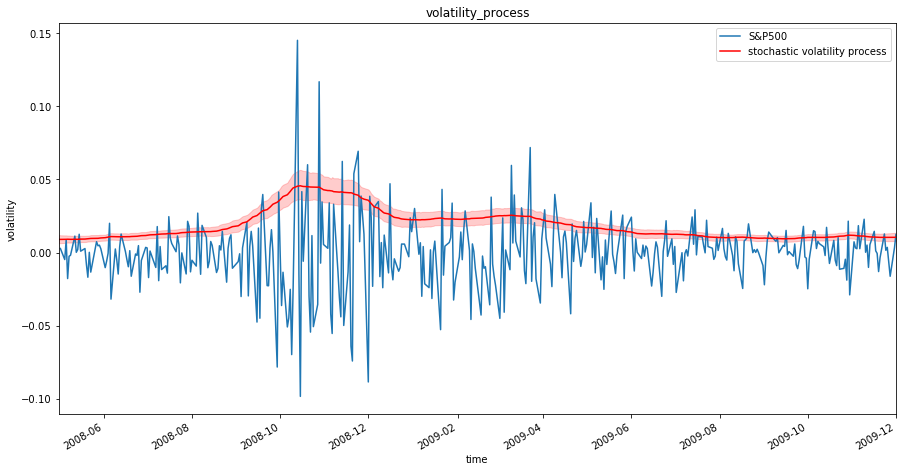

In [25]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15, 8))
returns.plot(ax=ax)
samps = pd.DataFrame(columns=['S.{}'.format(i) for i in range(1000)], 
                     data=1./np.exp(trace['s',::2]).T, index=returns.index)
# samps['date']=returns.index.values()
ax.plot(samps.index, samps.mean(axis=1), 'r');
ax.fill_between(samps.index, samps.quantile(.1,axis=1), 
                samps.quantile(.9,axis=1), color='r', alpha=0.2)
# sns.tsplot(samps, time='date')

ax.set(title='volatility_process', xlabel='time', ylabel='volatility');
ax.legend(['S&P500', 'stochastic volatility process'])
# pd.DataFrame.quantile()

## Baseball Trajectory

If you have purely mathematical expressions as the node RV values, you can use the `exprs` attribute to define them. All node references are determined automatically, and math functions available in default `pymc3.math` or standard python can be used. Just beware, outside references to variables is not allowed (i.e. bayes-net must be self-contained), unless you format the string (i.e. like using python 3.6's `f'{x}+{y}'` for externally defined floats, etc).  

**`BEWARE`** The current implementation of this (designed for compatibility with PMML (XML) bayes-nets) utilizes a call to `eval()` python function. **Do not use this unless you can absolutely trust the string being used in `exprs`**

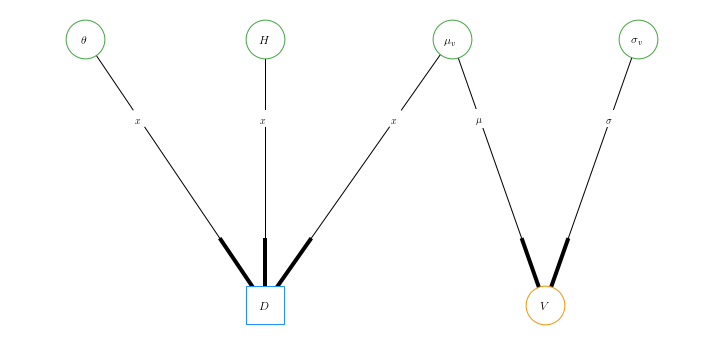

In [26]:
from pymc3.math import sin, cos, sqrt
from theano.tensor import mean

#synthetic test throws
np.random.seed(19806)  # random.org
v_obsv = np.random.normal(loc=24., scale=1., size=10)  # m/s

# gravity
g = 9.81  # m/s**2 

D = BayesianNetwork()
D.add_node('theta', 
           lower=np.pi/4.-.1, 
           upper=np.pi/4.+.1,
           dist_type='Uniform')  # close to 45deg
D.add_node('H', 
           lower=1.,
           upper=2.,
           dist_type='Uniform')  # about human-height

D.add_node('mu_v',
           lower=1., 
           upper=30.,
           dist_type='Uniform')  # from slow to best available
D.add_node('sd_v', 
           lower=0.1,
           upper=2.,
           dist_type='Uniform')  # something

D.add_node('V', 
#            mu=lambda: D.d('mu_v'), 
#            sd=lambda: D.d('sd_v'),
           exprs = {'mu': 'mu_v',
                    'sd': 'sd_v'},
           dist_type='Normal')

D.add_edge('mu_v', 'V', var='mu')
D.add_edge('sd_v', 'V', var='sd')

D.add_node('D', 
#            var=distance_f, 
           exprs = {'var': f'mu_v*cos(theta)*(mu_v*sin(theta) + sqrt((mu_v*sin(theta))**2+2*{g}*H))/{g}'},
           dist_type='Deterministic')
D.add_edges_from([(i, 'D') for i in ['theta', 'H', 'mu_v']], var='var')

draw_net(D, pretty=True)

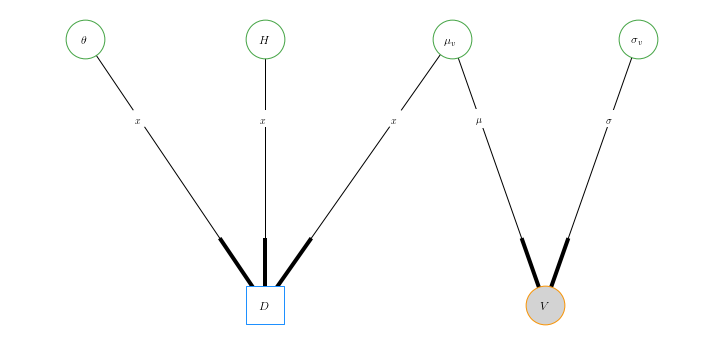

In [27]:
# add observations
O = D.copy()
O.node['V']['observed'] = v_obsv
draw_net(O, pretty=True)

theta
root node; keys:  ['upper', 'lower']
H
root node; keys:  ['upper', 'lower']
mu_v
root node; keys:  ['upper', 'lower']
sd_v
root node; keys:  ['upper', 'lower']
V
child node; keys:  ['sd', 'mu']
D


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


child node; keys:  ['var']


100%|█████████▉| 5490/5500 [00:28<00:00, 179.67it/s]/home/tbsexton/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.703562927814, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/home/tbsexton/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 570 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 5500/5500 [00:28<00:00, 190.87it/s]


theta
root node; keys:  ['upper', 'lower']
H
root node; keys:  ['upper', 'lower']
mu_v


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


root node; keys:  ['upper', 'lower']
sd_v
root node; keys:  ['upper', 'lower']
V
child node; keys:  ['observed', 'sd', 'mu']
D
child node; keys:  ['var']


100%|██████████| 5500/5500 [00:06<00:00, 910.47it/s] 


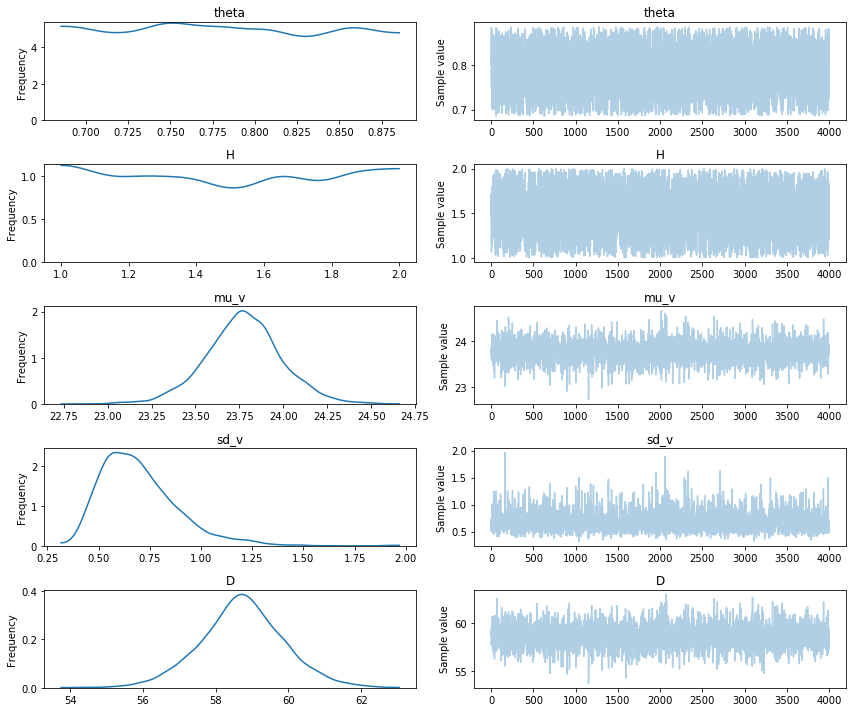

In [28]:
with pm.Model() as prior_model:
    instantiate_pm(D, evaluate_exprs=True)
    prior_trace=pm.sample(5000)
    
# pm.traceplot(proj_trace[1000:]);, njobs=4

with pm.Model() as projectile_model:
    instantiate_pm(O, evaluate_exprs=True)
    proj_trace=pm.sample(5000)
    
pm.traceplot(proj_trace[1000:]);
    

In [29]:
# a Trajectory Function, height as func. of distance
def y(h, thet, v, x):
    a = x.T.dot(np.tan(np.atleast_2d(thet)))
    b = np.atleast_2d(g/(2*v*np.cos(thet))**2).T.dot(x**2).T
    return h+a-b

samps = 1000
x = np.atleast_2d(np.arange(0,200))
y_pri = y(prior_trace['H', -samps:],
          prior_trace['theta', -samps:],
          prior_trace['mu_v', -samps:], 
          x)
y_pri[y_pri<0.]=0

y_pos = y(proj_trace['H', -samps:],
          proj_trace['theta', -samps:],
          proj_trace['mu_v', -samps:], 
          x)
y_pos[y_pos<0.]=0
pri = pd.DataFrame(columns=[f'S.{i}' for i in range(samps)], 
                     data=y_pri)
pos = pd.DataFrame(columns=[f'S.{i}' for i in range(samps)], 
                     data=y_pos)
pos.head()

# y_pri.shape

,S.0,S.1,S.2,S.3,S.4,S.5,S.6,S.7,S.8,S.9,...,S.990,S.991,S.992,S.993,S.994,S.995,S.996,S.997,S.998,S.999
0,1.311804,1.482734,1.547637,1.786735,1.134505,1.192410,1.709947,1.351797,1.541606,1.140818,...,1.528790,1.860363,1.357782,1.671387,1.605147,1.520043,1.202957,1.821310,1.355518,1.446841
1,2.135474,2.359235,2.614563,2.960164,2.251835,2.282309,2.779974,2.562295,2.357460,2.137691,...,2.730460,2.835751,2.252651,2.544672,2.478984,2.609105,2.404199,3.020951,2.526575,2.490913
2,2.944693,3.220742,3.663270,4.112716,3.349673,3.353074,3.831486,3.750927,3.158787,3.117493,...,3.910737,3.793904,3.131814,3.402590,3.337313,3.679035,3.583952,4.199195,3.677096,3.516840
3,3.739459,4.067253,4.693759,5.244393,4.428018,4.404704,4.864483,4.917694,3.945587,4.080226,...,5.069622,4.734822,3.995272,4.245140,4.180135,4.729832,4.742217,5.356043,4.807082,4.524620
4,4.519773,4.898770,5.706029,6.355194,5.486872,5.437201,5.878965,6.062596,4.717859,5.025889,...,6.207116,5.658505,4.843025,5.072322,5.007450,5.761495,5.878992,6.491495,5.916532,5.514255


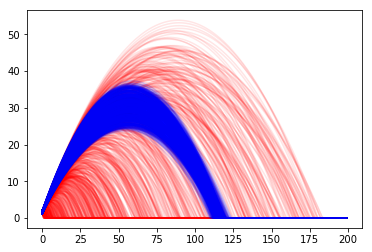

In [30]:
plt.plot(y_pri, color='r', alpha=.1);
plt.plot(y_pos, color='b', alpha=.1);
# plt.ylim(0,50)
# plt.legend()
# plt.xlim(0,50)

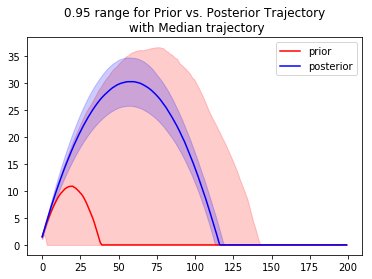

In [31]:
from scipy.stats import tmean

plt.plot(pri.index, np.median(pri, axis=1), 'r', label='prior');
plt.fill_between(pri.index, pri.quantile(.1,axis=1, interpolation='higher'), 
                pri.quantile(.9,axis=1, interpolation='higher'), color='r', alpha=0.2)
plt.plot(pos.index, np.median(pos, axis=1), 'b', label='posterior');
plt.fill_between(pos.index, pos.quantile(.1,axis=1, interpolation='higher'), 
                pos.quantile(.9,axis=1, interpolation='higher'), color='b', alpha=0.2)
plt.title('0.95 range for Prior vs. Posterior Trajectory\n with Median trajectory')
plt.legend()

Our uncertainty about the initial velocity really drags down our median guess about the trajectory path (this median should really be weighted accrding to the way distance scales with velocity). The data about velocity upon exit really influences our belief about the entire physical system

To properly "average" our trajectory, we need some way to define the space of functionals and average on that, i.e. somethign like Dynamic Time Warping, perhaps. 